In [1]:
from cortexlib.mouse import CortexlabMouse
from cortexlib.simclr import PreTrainedSimCLRModel
from cortexlib.images import CortexlabImages
from cortexlib.predictor import NeuralResponsePredictor
import pandas as pd

new_mouse = CortexlabMouse('m03_d4')
old_mouse = CortexlabMouse('m03_d4_original')

print(f'New mouse image ids: {new_mouse.image_ids}')
print(f'New mouse image ids length: {len(new_mouse.image_ids)}')
print(f'Old mouse image ids: {old_mouse.image_ids}')
print(f'Old mouse image ids length: {len(old_mouse.image_ids)}')

New mouse image ids: [1.000e+00 2.000e+00 3.000e+00 ... 1.858e+03 1.859e+03 1.860e+03]
New mouse image ids length: 1585
Old mouse image ids: [1.000e+00 2.000e+00 3.000e+00 ... 1.858e+03 1.859e+03 1.860e+03]
Old mouse image ids length: 1573


In [2]:
def run(mouse: CortexlabMouse):
    null_srv_all_neurons = mouse.compute_null_all_neurons(n_shuffles=100)
    real_srv_all_neurons = mouse.compute_real_srv_all_neurons()
    reliable_neuron_indices = mouse.get_reliable_neuron_indices(
                null_srv_all_neurons, real_srv_all_neurons, percentile_threshold=99)
    neural_responses_mean, neural_responses, _ = mouse.get_responses_for_reliable_neurons(reliable_neuron_indices, real_srv_all_neurons, num_neurons=500)

    simclr = PreTrainedSimCLRModel()

    settings = simclr.get_image_settings()
    images = CortexlabImages(
        size=settings['size'],
        channels=settings['channels'],
        normalise_mean=settings['mean'], 
        normalise_std=settings['std'],
        rescale_per_image=settings['rescale_per_image'],
    )

    image_dataset = images.load_images_shown_to_mouse(mouse.image_ids)
    print(f"Image ids: {mouse.image_ids}")

    simclr_feats, labels = simclr.extract_features(image_dataset)
    print(f"Labels: {labels}")

    num_images = simclr_feats['layer1'].shape[0]
    split = NeuralResponsePredictor.get_train_test_indexes(num_images)
    fev_results = []

    n_pcs = 50
    layer = 'layer3'

    predictor = NeuralResponsePredictor(
        reduce_image_representation_to_n_pcs=n_pcs, 
        neural_data_pc_index=0,
        train_idx=split['train_idx'],
        test_idx=split['test_idx'],
    )
    fev = predictor.compute_fev(simclr_feats[layer], neural_responses)

    fev_results.append({
        'layer': layer,
        'n_pcs': n_pcs,
        'test_r2': fev['test_r2'],
        'mean_fev': fev['mean_fev']
    })

    return pd.DataFrame(fev_results)

In [3]:
old_mouse_results = run(old_mouse)
old_mouse_results

15:20:16 | INFO     | ℹ️ Already downloaded pretrained SimCLR model


Image ids: [1.000e+00 2.000e+00 3.000e+00 ... 1.858e+03 1.859e+03 1.860e+03]


  0%|          | 0/25 [00:00<?, ?it/s]

Labels: tensor([   1,    2,    3,  ..., 1858, 1859, 1860])


,layer,n_pcs,test_r2,mean_fev
0,layer3,50,0.462741,0.488455


In [4]:
new_mouse_results = run(new_mouse)
new_mouse_results

15:21:14 | INFO     | ℹ️ Already downloaded pretrained SimCLR model


Image ids: [1.000e+00 2.000e+00 3.000e+00 ... 1.858e+03 1.859e+03 1.860e+03]


  0%|          | 0/25 [00:00<?, ?it/s]

Labels: tensor([   1,    2,    3,  ..., 1858, 1859, 1860])


,layer,n_pcs,test_r2,mean_fev
0,layer3,50,0.199121,0.211957


In [5]:
import numpy as np

np.setdiff1d(new_mouse.image_ids, old_mouse.image_ids)
np.setdiff1d(old_mouse.image_ids, new_mouse.image_ids)

array([], dtype=float64)

In [6]:
(np.array_equal(new_mouse.image_ids, old_mouse.image_ids))

False

In [7]:
# Get PC1 on 1573-image version
from sklearn.decomposition import PCA

mean_old = old_mouse.neural_responses.mean(axis=1)
pc1_old = PCA(n_components=1).fit_transform(mean_old)[:, 0]

# Get PC1 on 1585-image version
mean_new = new_mouse.neural_responses.mean(axis=1)
pc1_new = PCA(n_components=1).fit_transform(mean_new)[:, 0]

# Align on shared image IDs
shared_ids = np.intersect1d(old_mouse.image_ids, new_mouse.image_ids)
old_idx = [np.where(old_mouse.image_ids == i)[0][0] for i in shared_ids]
new_idx = [np.where(new_mouse.image_ids == i)[0][0] for i in shared_ids]

# Compare PC1s on same images
from scipy.stats import pearsonr
r, _ = pearsonr(pc1_old[old_idx], pc1_new[new_idx])
print(f"Correlation of old and new PC1: r = {r:.3f}")

Correlation of old and new PC1: r = 0.937


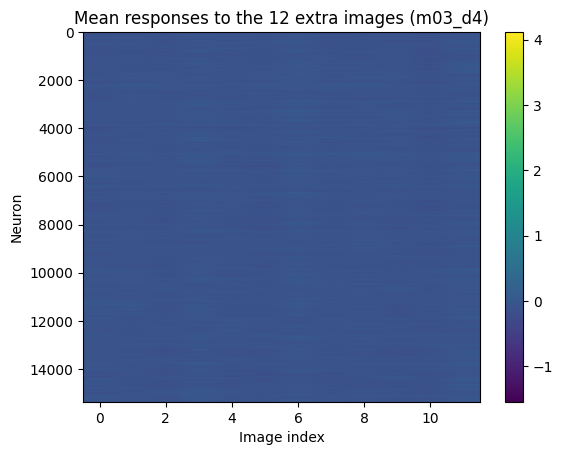

In [8]:
extra_ids = np.setdiff1d(new_mouse.image_ids, old_mouse.image_ids)
extra_idx = [i for i, id_ in enumerate(new_mouse.image_ids) if id_ in extra_ids]
extra_resps = new_mouse.neural_responses[extra_idx]

# Plot heatmap
import matplotlib.pyplot as plt
plt.imshow(extra_resps.mean(axis=1).T, aspect='auto', cmap='viridis')
plt.title("Mean responses to the 12 extra images (m03_d4)")
plt.xlabel("Image index")
plt.ylabel("Neuron")
plt.colorbar()

Extra image IDs: [  42.   43.   96.  251.  508.  783.  876.  972. 1171. 1218. 1380. 1587.]


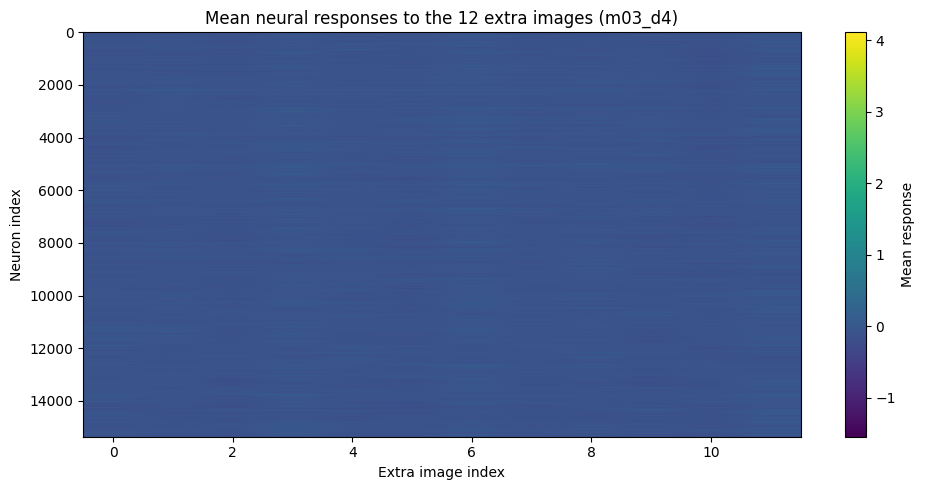

In [9]:
extra_ids = np.setdiff1d(new_mouse.image_ids, old_mouse.image_ids)
print(f"Extra image IDs: {extra_ids}")
extra_idx = np.nonzero(np.isin(new_mouse.image_ids, extra_ids))[0]
extra_resps = new_mouse.neural_responses[extra_idx]  # Shape: (12, 2, n_neurons)
extra_resps_mean = extra_resps.mean(axis=1)  # Shape: (12, n_neurons)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.imshow(extra_resps_mean.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Mean response')
plt.xlabel("Extra image index")
plt.ylabel("Neuron index")
plt.title("Mean neural responses to the 12 extra images (m03_d4)")
plt.tight_layout()
plt.show()

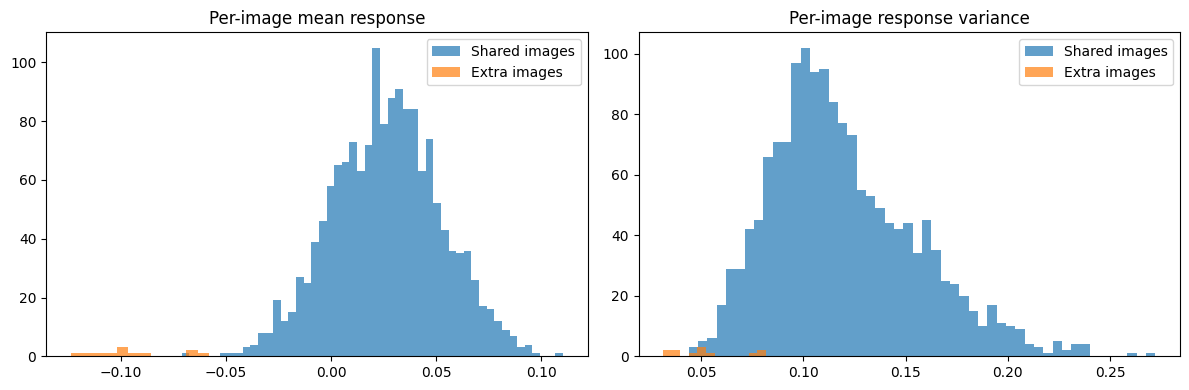

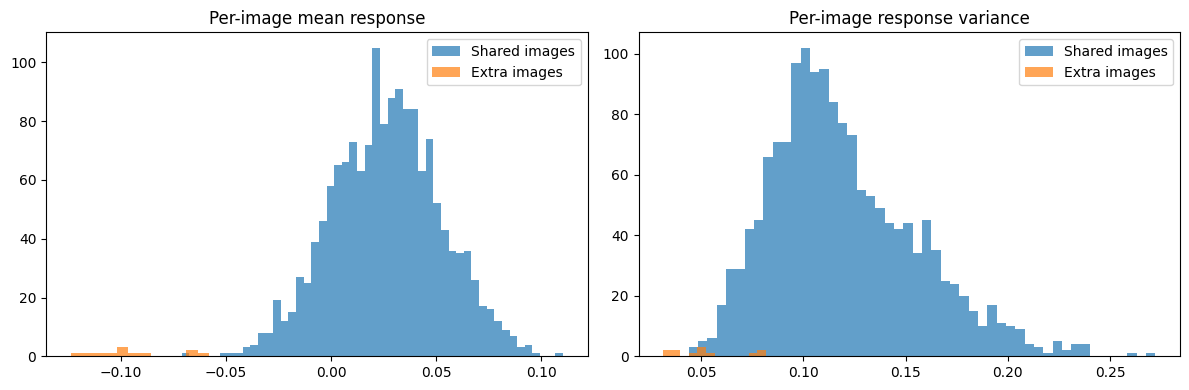

In [ ]:
import matplotlib.pyplot as plt

# Full image ID list and responses
image_ids = new_mouse.image_ids
neural_responses = new_mouse.neural_responses  # shape: (1585, 2, n_neurons)

# Identify extra and shared image IDs
extra_ids = np.setdiff1d(new_mouse.image_ids, old_mouse.image_ids)
shared_ids = np.setdiff1d(new_mouse.image_ids, extra_ids)

# Indices for extra and shared images
extra_idx = np.nonzero(np.isin(image_ids, extra_ids))[0]
shared_idx = np.nonzero(np.isin(image_ids, shared_ids))[0]

# Extract responses
resps_extra = neural_responses[extra_idx]   # shape: (12, 2, n_neurons)
resps_shared = neural_responses[shared_idx] # shape: (1573, 2, n_neurons)

# Mean across repeats
resps_extra_mean = resps_extra.mean(axis=1)   # shape: (12, n_neurons)
resps_shared_mean = resps_shared.mean(axis=1) # shape: (1573, n_neurons)

# Compute per-image mean and variance across neurons
mean_extra = resps_extra_mean.mean(axis=1)
mean_shared = resps_shared_mean.mean(axis=1)

var_extra = resps_extra_mean.var(axis=1)
var_shared = resps_shared_mean.var(axis=1)

# Plot histograms
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(mean_shared, bins=50, alpha=0.7, label='Shared images')
axs[0].hist(mean_extra, bins=12, alpha=0.7, label='Extra images')
axs[0].set_title('Per-image mean response')
axs[0].legend()

axs[1].hist(var_shared, bins=50, alpha=0.7, label='Shared images')
axs[1].hist(var_extra, bins=12, alpha=0.7, label='Extra images')
axs[1].set_title('Per-image response variance')
axs[1].legend()

plt.tight_layout()
plt.show()

# Compute per-image mean and variance across neurons
mean_extra = resps_extra_mean.mean(axis=1)
mean_shared = resps_shared_mean.mean(axis=1)

var_extra = resps_extra_mean.var(axis=1)
var_shared = resps_shared_mean.var(axis=1)

# Plot histograms
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(mean_shared, bins=50, alpha=0.7, label='Shared images')
axs[0].hist(mean_extra, bins=12, alpha=0.7, label='Extra images')
axs[0].set_title('Per-image mean response')
axs[0].legend()

axs[1].hist(var_shared, bins=50, alpha=0.7, label='Shared images')
axs[1].hist(var_extra, bins=12, alpha=0.7, label='Extra images')
axs[1].set_title('Per-image response variance')
axs[1].legend()

plt.tight_layout()
plt.show()